# Create Land Surface Temparature (LST) map from Landsat 8 data

In [1]:
# Add the parent directory to the path to make imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pathlib import Path

import folium
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask

from src import utils

### Paths

In [3]:
# ID of the Landsat 8 files
id = "LC08_L1TP_193023_20220803_20220806_02_T1"

In [4]:
# Directory paths
dir_root = Path("..")
dir_data = Path(dir_root, "data")
dir_data_landsat = Path(dir_data, "landsat")
dir_source = Path(dir_data_landsat, "source", id)
dir_output = Path(dir_data_landsat, "output")
dir_preprocessed = Path(dir_data_landsat, "preprocessed")

# File paths
geojson_path = Path(dir_data, "geojson", "berlin.geojson")
mtl_path = Path(dir_source, id + "_MTL.txt")

# Bands
band_4_path = Path(dir_source, id + "_B4.TIF")  # Red 
band_5_path = Path(dir_source, id + "_B5.TIF")  # Near Infrared
band_10_path = Path(dir_source, id + "_B10.TIF") # Thermal Infrared

# Paths clipped to GeoJson
band_4_clipped_path = utils.clip_to_geojson(band_4_path, geojson_path, dir_output)
band_5_clipped_path = utils.clip_to_geojson(band_5_path, geojson_path, dir_output)
band_10_clipped_path = utils.clip_to_geojson(band_10_path, geojson_path, dir_output)
# TODO: Somehow clip_to_geojson() deletes MTL file

# Output file paths
file_lst = Path(dir_output, "temperature_lst.tif")
file_lst_repr = Path(dir_output, "temperature_lst_reprojected.tif")
file_lst_repr_colored = Path(dir_output, "temperature_lst_reprojected_colored.tif")

file_ndvi = Path(dir_output, "ndvi.tif")
file_ndvi_repr = Path(dir_output, "ndvi_reprojected.tif")
file_ndvi_repr_colored = Path(dir_output, "ndvi_reprojected_colored.tif")

file_emissivity = Path(dir_output, "emissivity.tif")
file_emissivity_repr = Path(dir_output, "emissivity_reprojected.tif")
file_emissivity_repr_colored = Path(dir_output, "emissivity_reprojected_colored.tif")

Saved clipped file to ../data/landsat/output/LC08_L1TP_193023_20220803_20220806_02_T1_B4_clipped.TIF
Saved clipped file to ../data/landsat/output/LC08_L1TP_193023_20220803_20220806_02_T1_B5_clipped.TIF
Saved clipped file to ../data/landsat/output/LC08_L1TP_193023_20220803_20220806_02_T1_B10_clipped.TIF


### Calculate metrics

In [5]:
ndvi = utils.calc_ndvi(
    band_4_clipped_path, band_5_clipped_path, file_ndvi
)

Saved NDVI to ../data/landsat/output/ndvi.tif


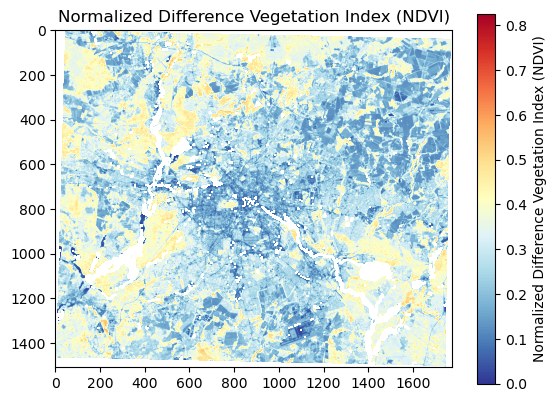

In [6]:
plt.imshow(ndvi, cmap="RdYlBu_r")
plt.colorbar(label="Normalized Difference Vegetation Index (NDVI)")
plt.title("Normalized Difference Vegetation Index (NDVI)")
plt.show()

In [7]:
lst = utils.calc_lst(
    band_4_clipped_path, band_5_clipped_path, band_10_clipped_path, file_lst
)

Saved Land Surface Temperature (LST) to ../data/landsat/output/temperature_lst.tif


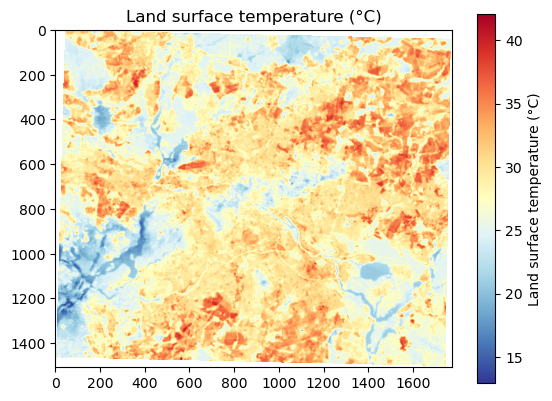

In [8]:
plt.imshow(lst, cmap="RdYlBu_r")
plt.colorbar(label="Land surface temperature (°C)")
plt.title("Land surface temperature (°C)")
plt.show()

In [9]:
emissivity = utils.calc_emissivity(
    band_4_clipped_path, band_5_clipped_path, file_emissivity
)

Saved Emissivity to ../data/landsat/output/emissivity.tif


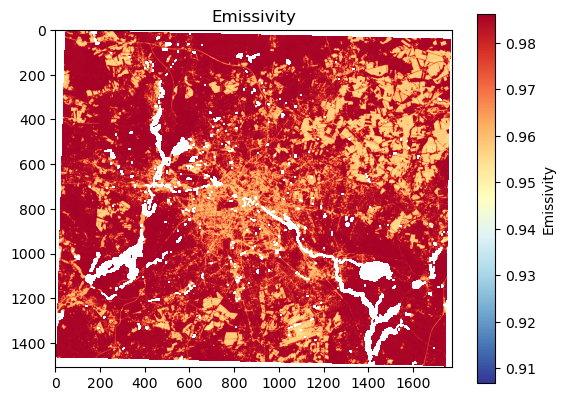

In [10]:
plt.imshow(emissivity, cmap="RdYlBu_r")
plt.colorbar(label="Emissivity")
plt.title("Emissivity")
plt.show()

### Change projection

In [ ]:
reprojected_ndvi, reprojected_ndvi_array = utils.reproject_geotiff(
    file_ndvi, file_ndvi_repr, 4326
)

In [ ]:
reprojected_img, reprojected_img_array = utils.reproject_geotiff(
    file_lst, file_lst_repr, 4326
)

In [11]:
reprojected_emissivity, reprojected_emissivity_array = utils.reproject_geotiff(
    file_emissivity, file_emissivity_repr, 4326
)

In [ ]:
with rasterio.open(file_lst_repr) as src:
    temperature_reprojected = src.read(1)

plt.imshow(temperature_reprojected, cmap="RdYlBu_r")
plt.colorbar(label="Land surface temperature (°C)")
plt.title("Land surface temperature (°C)")

### Change colors

In [13]:
colored_img_ndvi, colored_img_ndvi_array = utils.create_rgba_color_image(
    reprojected_ndvi.name, file_ndvi_repr_colored
)

NameError: name 'reprojected_ndvi' is not defined

In [ ]:
colored_img, colored_img_array = utils.create_rgba_color_image(
    reprojected_img.name, file_lst_repr_colored
)

In [12]:
colored_img_emissivity, colored_img_emissivity_array = utils.create_rgba_color_image(
    reprojected_emissivity.name, file_emissivity_repr_colored
)

In [ ]:
with rasterio.open(file_lst_repr_colored) as src:
    temperature_reprojected_colored = src.read(1)

plt.imshow(temperature_reprojected_colored, cmap="RdYlBu_r");

### Plot Folium temperature map

In [16]:
with rasterio.open(file_ndvi_repr_colored) as colored_ndvi:
    # Load GeoTIFF as ndarray
    colored_ndvi_array = colored_ndvi.read()

    # Move channel axis to third position
    colored_ndvi_array = np.moveaxis(colored_ndvi_array, source=0, destination=2)

In [17]:
with rasterio.open(file_lst_repr_colored) as colored_img:
    # Load GeoTIFF as ndarray
    colored_img_array = colored_img.read()

    # Move channel axis to third position
    colored_img_array = np.moveaxis(colored_img_array, source=0, destination=2)

In [18]:
with rasterio.open(file_emissivity_repr_colored) as colored_emissivity:
    # Load GeoTIFF as ndarray
    colored_emissivity_array = colored_emissivity.read()

    # Move channel axis to third position
    colored_emissivity_array = np.moveaxis(colored_emissivity_array, source=0, destination=2)


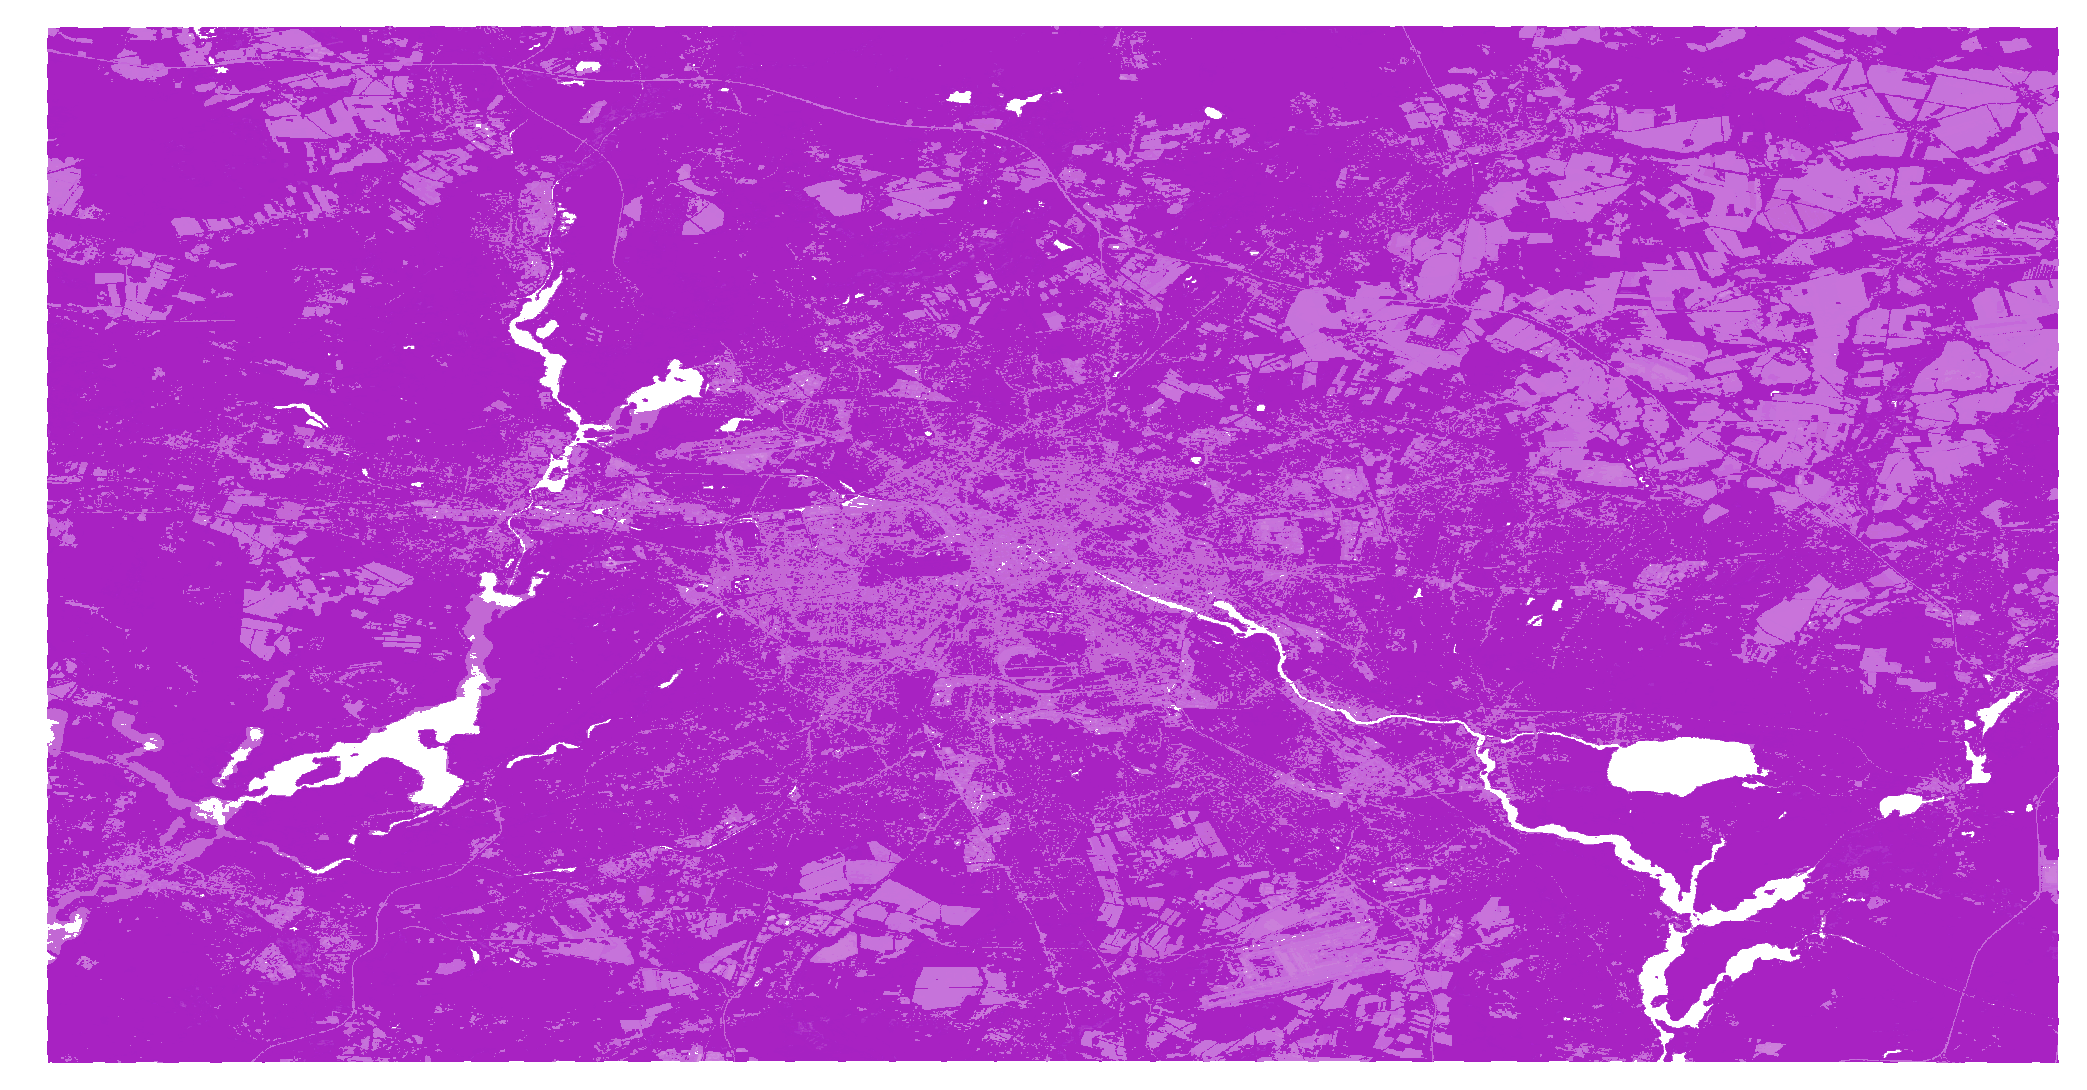
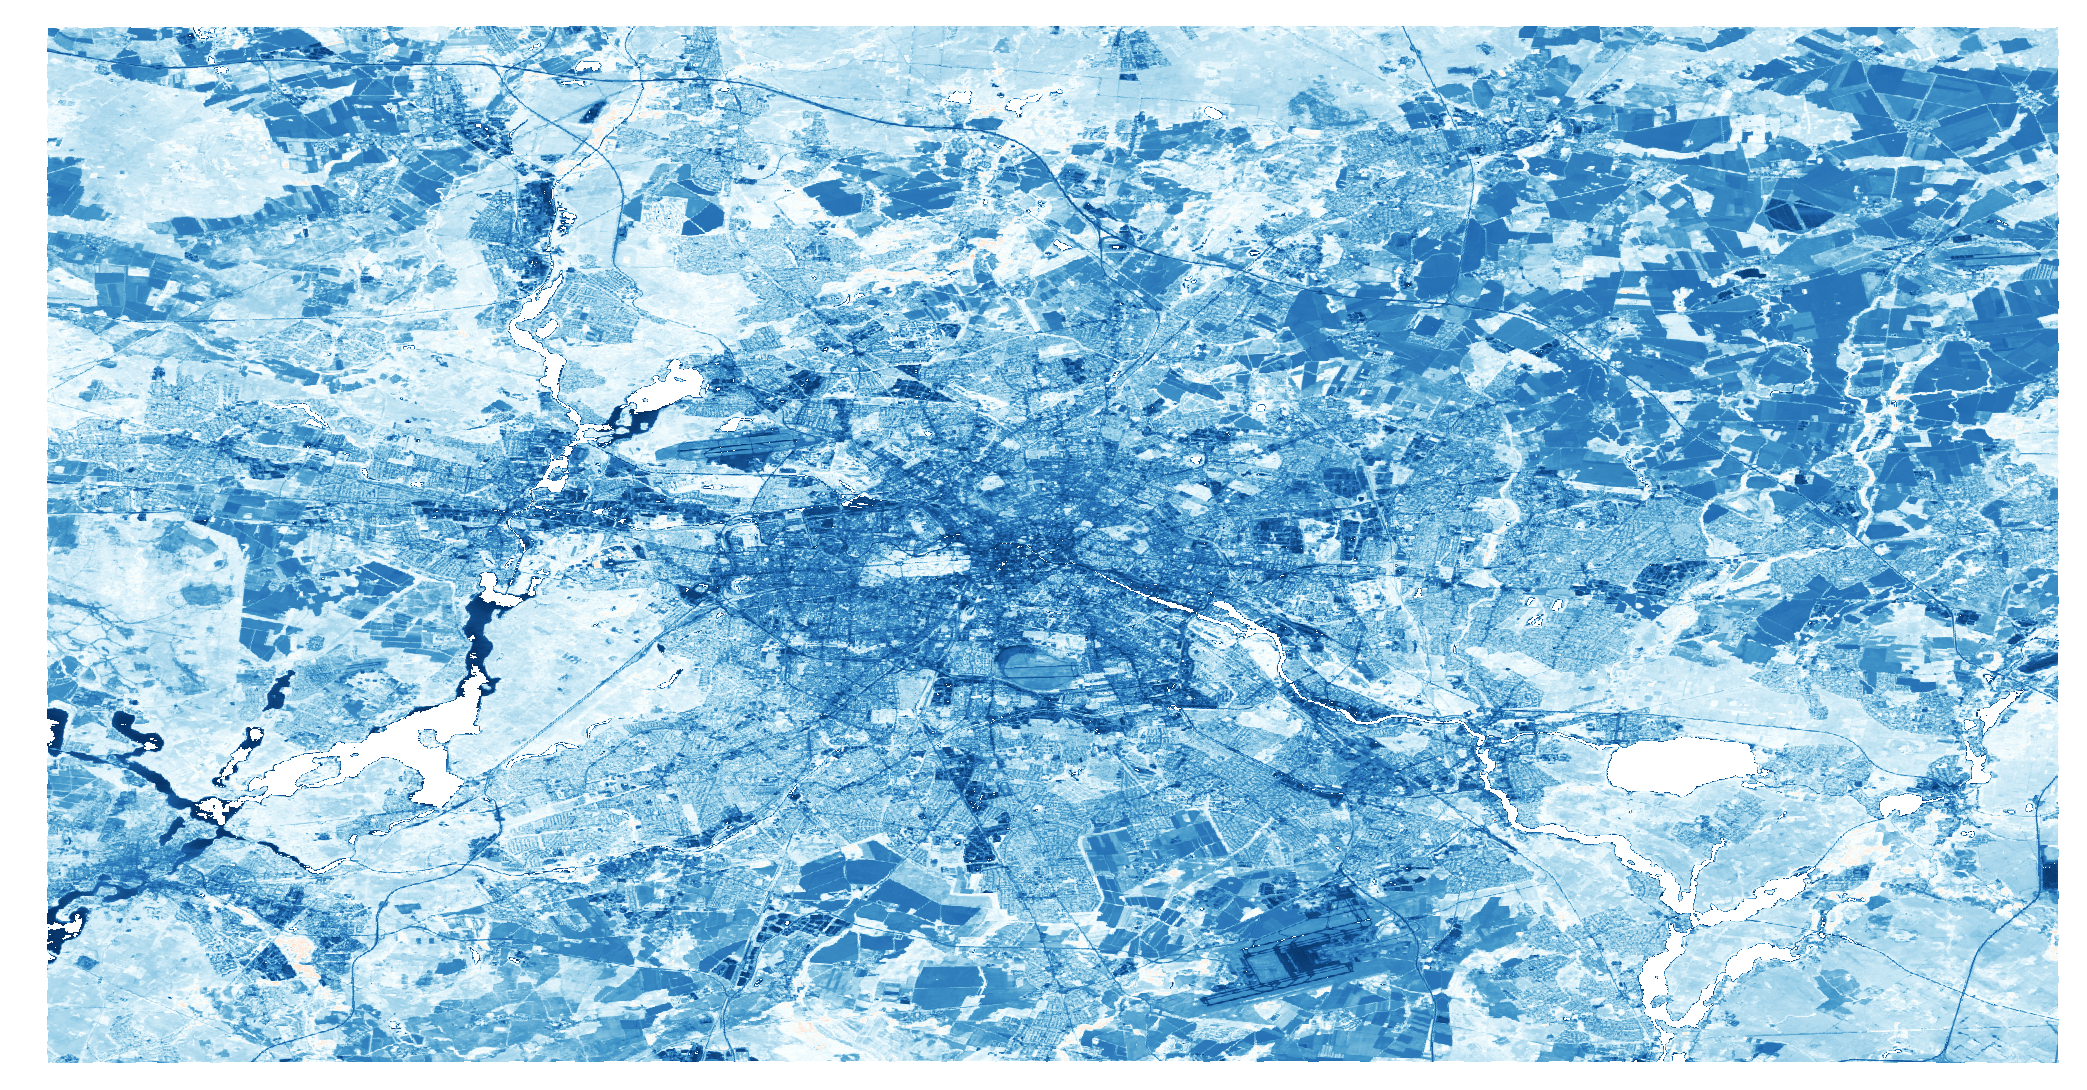
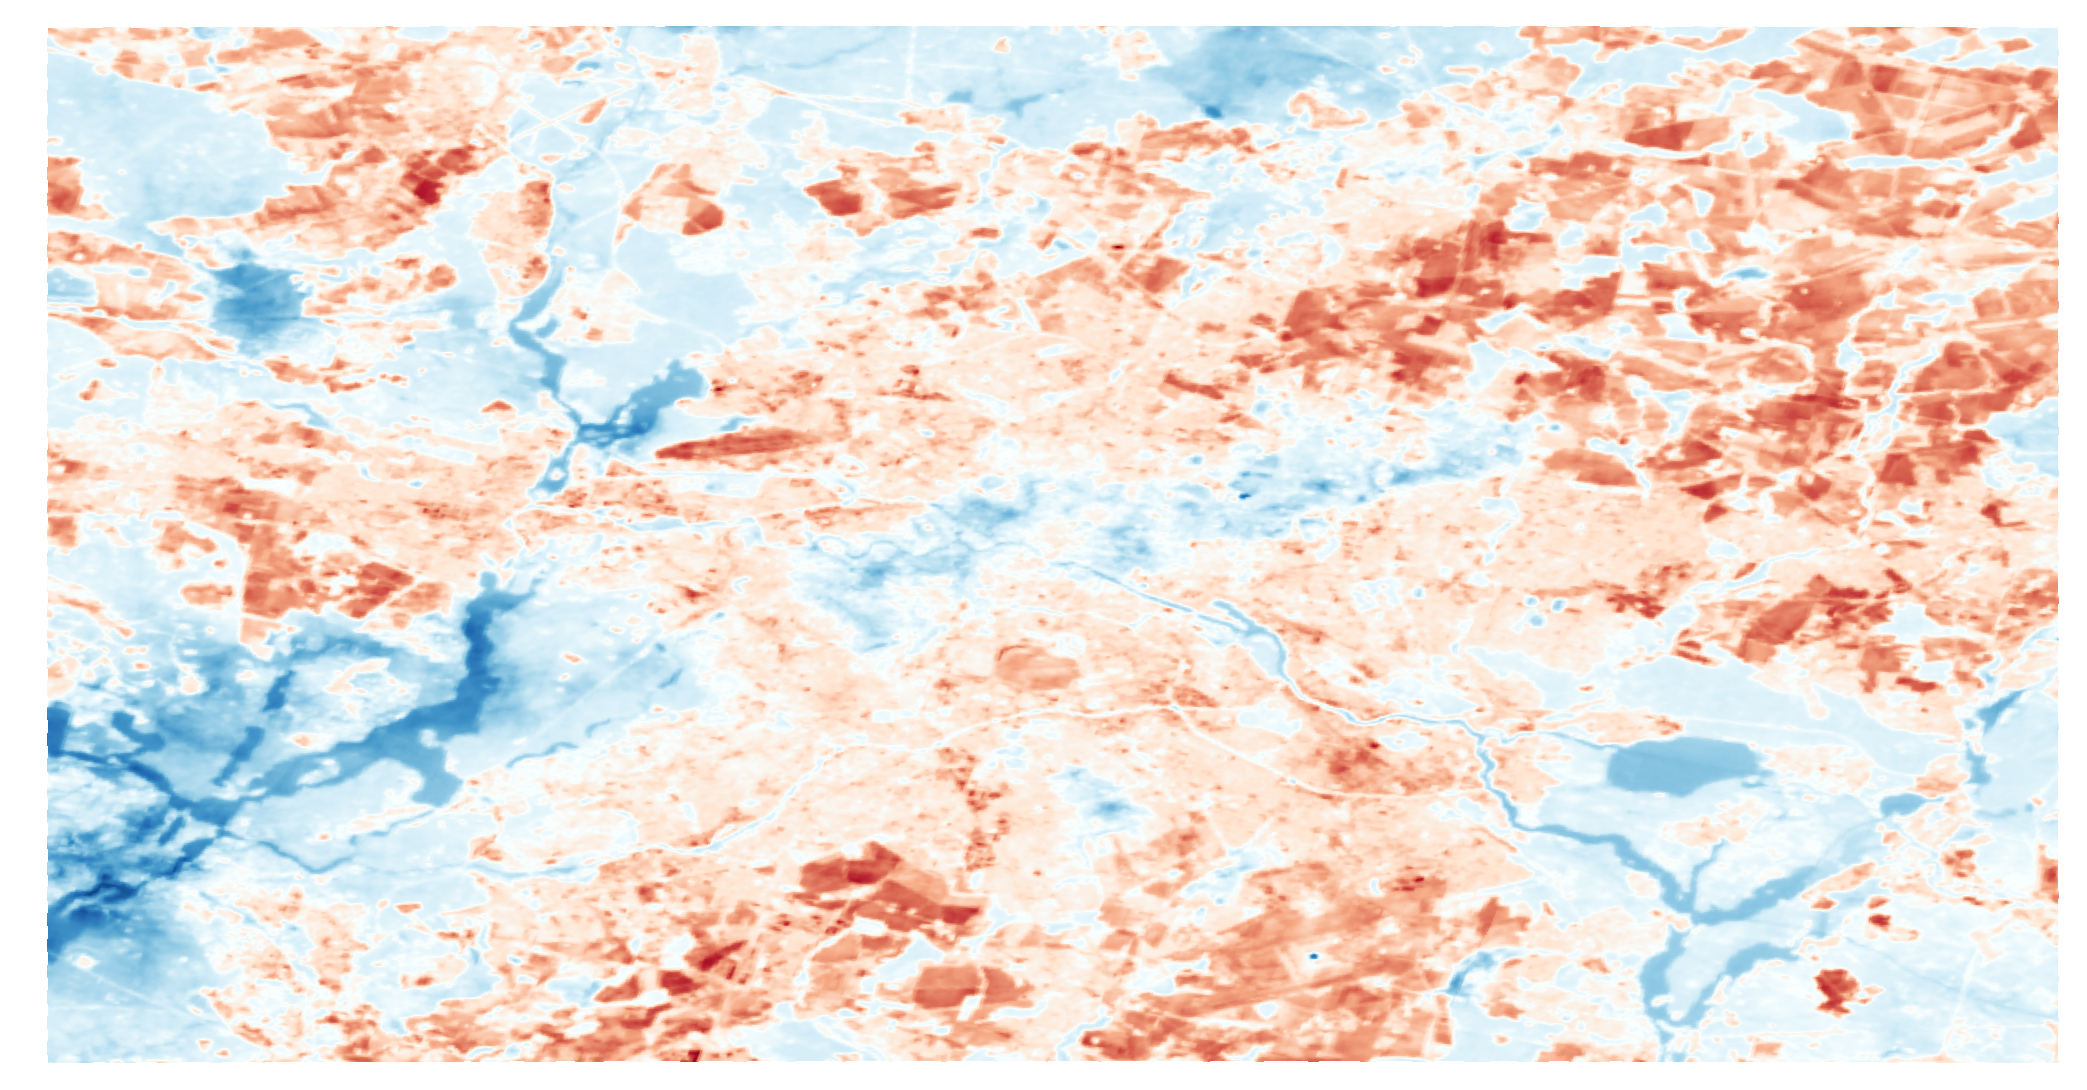

In [19]:
m = folium.Map(
    location=[
        (colored_img.bounds.bottom + colored_img.bounds.top) / 2,
        (colored_img.bounds.left + colored_img.bounds.right) / 2,
    ],
    tiles="Stamen Terrain",
    zoom_start=11,
)

# Add Emissivity layer
folium.raster_layers.ImageOverlay(
    image=colored_emissivity_array,
    name="Emissivity",
    opacity=0.75,
    bounds=[
        [colored_emissivity.bounds.bottom, colored_emissivity.bounds.left],
        [colored_emissivity.bounds.top, colored_emissivity.bounds.right],
    ],
).add_to(m)

# Add NDVI layer
folium.raster_layers.ImageOverlay(
    image=colored_ndvi_array,
    name="Normalized Difference Vegetation Index (NDVI)",
    opacity=0.75,
    bounds=[
        [colored_ndvi.bounds.bottom, colored_ndvi.bounds.left],
        [colored_ndvi.bounds.top, colored_ndvi.bounds.right],
    ],
).add_to(m)

# Add Land Surface Temperature layer
folium.raster_layers.ImageOverlay(
    image=colored_img_array,
    name="Land Surface Temperature",
    opacity=0.75,
    bounds=[
        [colored_img.bounds.bottom, colored_img.bounds.left],
        [colored_img.bounds.top, colored_img.bounds.right],
    ],
).add_to(m)

folium.LayerControl().add_to(m)

# colormap.caption = "Surface temperature"
# m.add_child(colormap)

# Set bounds TODO: Not working
# m.fit_bounds(
#     [
#         [colored_img.bounds.bottom, colored_img.bounds.left],
#         [colored_img.bounds.top, colored_img.bounds.right],
#     ]
# )

m